## ***Natural Languagem Processing*** to predict if a headline from a news website contains sarcasm - Data Analysis.

The task at hand involves predicting whether a given headline is **sarcastic** or not. This **binary classification problem** requires training a model to distinguish between genuinely factual statements and those that carry a sarcastic or ironic undertone. By analyzing a dataset of headlines labeled as sarcastic or non-sarcastic, the model can learn **patterns** in **language usage**, **word choice**, and **structure** that are often indicative of sarcasm. Successfully addressing this task will improve the accuracy of sentiment analysis models and enhance user experiences by helping systems better understand and process the nuances of **human language**.

In this file, the data will be analysed to get **information** and **insights** about the dataset.

In [ ]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, re, numpy as np, scipy.stats, nltk, string
from nltk import FreqDist
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import Word2Vec
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from wordcloud import WordCloud

nltk.download('rslp')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

In [97]:
sarcasm_df = pd.read_csv('sarcasm.csv')

sarcasm_df['headline'] = sarcasm_df['headline'].apply(lambda x: x.lower())

sarcasm_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Verifying **possible predictive variables**.

In order to check whether the website **hostname** can be used as a **predictive** variable, the website host name is extracted and the proportion of **sarcastic** headlines for each *alias* is observed.

In [98]:
pattern = r"^https://([^/]+)/"

sarcasm_df['article_host'] = sarcasm_df['article_link'].apply(lambda row: re.search(pattern, row)[1]).drop(columns=['article_link'])

sarcasm_df = sarcasm_df[['article_host', 'headline', 'is_sarcastic']]

sarcasm_df.tail(n=10)

,article_host,headline,is_sarcastic
26699,www.huffingtonpost.com,"what you should buy your 'basic' friend, accor...",0
26700,www.huffingtonpost.com,what's in your mailbox? tips on what to do whe...,0
26701,www.huffingtonpost.com,paul ryan is more of a con man than ever,0
26702,politics.theonion.com,pentagon to withhold budget figures out of res...,1
26703,www.theonion.com,pope francis wearing sweater vestments he got ...,1
26704,www.huffingtonpost.com,american politics in moral free-fall,0
26705,www.huffingtonpost.com,america's best 20 hikes,0
26706,www.huffingtonpost.com,reparations and obama,0
26707,www.huffingtonpost.com,israeli ban targeting boycott supporters raise...,0
26708,www.huffingtonpost.com,gourmet gifts for the foodie 2014,0


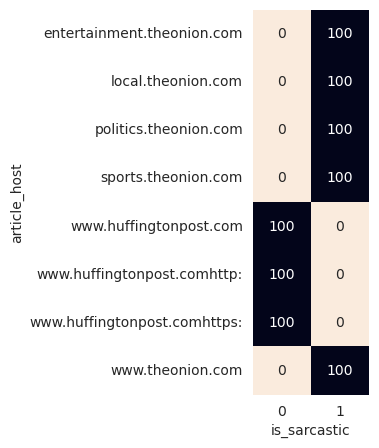

In [99]:
pivot = sarcasm_df.groupby(['article_host', 'is_sarcastic']).size().unstack(fill_value=0)
pivot = pivot.apply(lambda x: 100 * x / x.sum(), axis=1)

palette = sns.set_palette("muted")
sns.set_style("darkgrid")
fig = plt.figure(figsize=(1.5, 5))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='rocket_r', cbar=False)

plt.show()

* From the sarcastic headlines proportions, it is clear to see that a especific website hostname is related to a unique class of **is_sarcastic** target variable, therefore it **cannot be used as a predictive variable** on this *natural language processing* task in order to extract from a non-deterministic variables a model to understand a headlines's pattern from the websites.

### Checking **null** values in dataset.

In order to verify wether a **null values handling** on the dataset is necessary or not, null values are counted.

In [100]:
sarcasm_df.isna().sum()

article_host    0
headline        0
is_sarcastic    0
dtype: int64

* Based on the count, **no null values handling is needed**.

### Dataset balance **analysis**.

At first, to check the target attribute balance in the class, the proportion between the classes is ploted with horizontal bars.

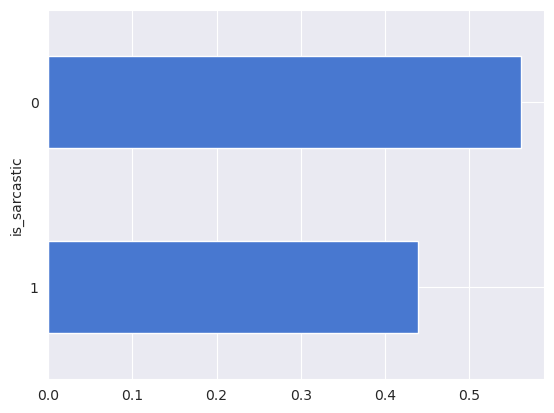

is_sarcastic
0    0.561047
1    0.438953
Name: proportion, dtype: float64

In [101]:
target_att_values = sarcasm_df['is_sarcastic'].value_counts(normalize=True)

target_att_values.sort_values().plot(kind='barh')
plt.show()

target_att_values

* According to the graph, it is clear to see that the classes are **disbalanced**, which implies a different way to deal with the database on the data analysis, model **training** and the model **evaluation** steps further ahead in this machine learning task.

### ***Tokenizing*** and checking the token count **distribution** between classes.

At this step, it is used the tokenize function along with the steeming method to extract the words's radicals and remove the stopwords with `nltk`.

In [102]:
english_stopwords, stemmer = set(stopwords.words('english')), PorterStemmer()

def extract_tokens(headline):
    return [stemmer.stem((word)) for word in word_tokenize(headline) if word not in english_stopwords and word not in string.punctuation]

sarcasm_df['tokens'] = sarcasm_df['headline'].apply(extract_tokens)

* After, in order to visualize if the number of **tokens** in a headline have some correlation with the sarcasm presence, it is made a **KDEplot** to check the attribute's distribution.

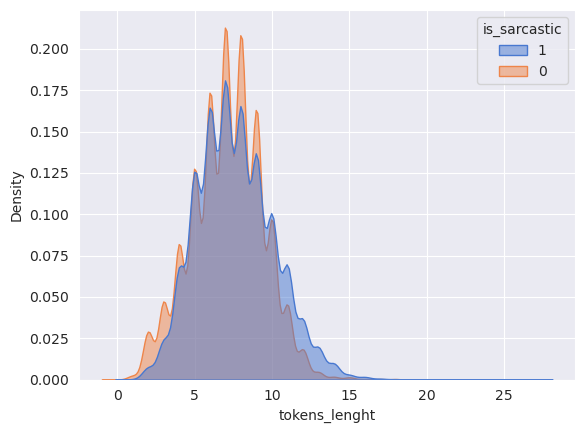

,count,mean,std,min,25%,50%,75%,max
is_sarcastic,,,,,,,,
0,14985.0,7.112513,2.282713,0.0,6.0,7.0,9.0,20.0
1,11724.0,7.613698,2.466278,1.0,6.0,7.0,9.0,27.0


In [103]:
sarcasm_df['tokens_lenght'] = sarcasm_df['tokens'].apply(lambda x: len(x))

sns.kdeplot(
    data=sarcasm_df, 
    x='tokens_lenght', 
    hue='is_sarcastic', 
    alpha=0.5, 
    common_norm=False, 
    hue_order=[1, 0],
    linewidth=1,
    fill=True,
    multiple='layer'
)

plt.show()

sarcasm_df.groupby('is_sarcastic')['tokens_lenght'].describe()

In [104]:
tokens_lenght_sarcasm_splited = sarcasm_df.groupby('is_sarcastic')['tokens_lenght']

print(f'Skewness: \n{tokens_lenght_sarcasm_splited.skew()}', end='\n\n')

print(f'Kurtosis: \n{tokens_lenght_sarcasm_splited.apply(lambda x: scipy.stats.kurtosis(x))}')

Skewness: 
is_sarcastic
0    0.013806
1    0.510309
Name: tokens_lenght, dtype: float64

Kurtosis: 
is_sarcastic
0    0.196428
1    0.986265
Name: tokens_lenght, dtype: float64


In [105]:
tokens_lenght_corr = sarcasm_df['is_sarcastic'].corr(sarcasm_df['tokens_lenght'], method='spearman')

print(f'The spearman correlation coeficient is: {tokens_lenght_corr:.4f}')

The spearman correlation coeficient is: 0.0800


* According to the image, it is clear to see that sarcastic headlines have, in general, a bigger **tonkens_lenght** amplitude, which means that the obervations are more sparsely distributed in the space and the non-sarcastic objects have a more concentrated number of tokens. 

* Based on the **descriptive statistics** measures, it is possible to observe the higher attribute's **amplitude** on **sarcastic** headlines according to the minimum, maximum values and the skewness, that shows an **assymetry** to the left duo it's positive value. In addition to that, the **kurtosis** shows a flatter curve on sarcastic texts, closer to a normal distribution.

* However, the ***Spearman*** correlation coeficient, method used to soften the high attribute's amplitude effect to the coeficient, represents a **low correlation mathematically**.

* Threfore, it is possibly awaited that the **tokens_lenght** attribute might have a certain statistical relevance for the model to learn, hypothesis that will be infered at the learning step.

### Verifying number of **different tokens** from each class.

At this step, the numbers of repeated tokens in a headline will be checked to compare if there is, in general, a repeated word proportion discrepancy based if there is sarcasm or not.

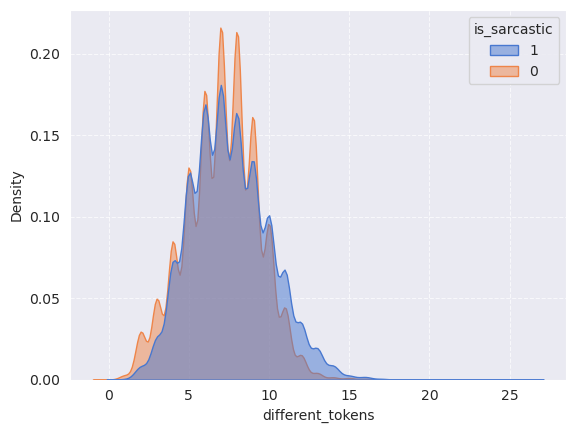

,count,mean,std,min,25%,50%,75%,max
is_sarcastic,,,,,,,,
0,14985.0,7.060060,2.256626,0.0,6.0,7.0,9.0,20.0
1,11724.0,7.549727,2.454604,1.0,6.0,7.0,9.0,26.0


In [106]:
sarcasm_df['different_tokens'] = sarcasm_df['tokens'].apply(lambda row: len(set(row)))

sns.kdeplot(
    data=sarcasm_df, 
    x='different_tokens', 
    hue='is_sarcastic', 
    alpha=0.5, 
    common_norm=False, 
    hue_order=[1, 0],
    linewidth=1,
    fill=True,
    multiple='layer'
)
plt.grid(linestyle='--', alpha=0.7)
plt.show()

sarcasm_df.groupby('is_sarcastic')['different_tokens'].describe()

In [107]:
different_tokens_sum = sarcasm_df.groupby('is_sarcastic')['different_tokens'].sum()
tokens_length_sum = sarcasm_df.groupby('is_sarcastic')['tokens_lenght'].sum()

different_tokens_sum / tokens_length_sum

is_sarcastic
0    0.992625
1    0.991598
dtype: float64

* Now, according to the graph and the **descriptive measures**, due to the **curves similarities** and the **actual proportion of multiple appearances** of a word in the headlines, it appears that the repeated token ratio is considerably **similar in both classes**. Therefore, there is **no indication of a correlation** between the proportion of frequent tokens in a sentense and sarcasm.

### Checking the **most frequent words** and the number of **unique tokens** in the common words.

First, the tokens with **more appearances** are verified and it the **proportion of unique tokens** in each class is checked.

In [108]:
words_non_sarcastic = [word for tokens in sarcasm_df[sarcasm_df['is_sarcastic'] == 0]['tokens'] for word in tokens if word not in string.punctuation]
words_sarcastic = [word for tokens in sarcasm_df[sarcasm_df['is_sarcastic'] == 1]['tokens'] for word in tokens if word not in string.punctuation]

most_common_non_sarcastic = FreqDist(words_non_sarcastic).most_common(500)
most_common_sarcastic = FreqDist(words_sarcastic).most_common(500)

In [109]:
unique_sarcastic = [(word, count) for word, count in most_common_sarcastic if word not in [word for word, count in most_common_non_sarcastic]]

unique_non_sarcastic = [(word, count) for word, count in most_common_non_sarcastic if word not in [word for word, count in most_common_sarcastic]]

print(f"""Unique most frequent tokens in sarcastic headlines:\n{unique_sarcastic[:20]}
\nUnique most frequent tokens in non sarcastic headlines:\n{unique_non_sarcastic[:20]}\n""")

Unique most frequent tokens in sarcastic headlines:
[('area', 479), ('local', 147), ('announc', 134), ('fuck', 113), ('introduc', 113), ('entir', 105), ('god', 105), ('employe', 105), ('self', 90), ('enough', 88), ('hour', 86), ('spend', 82), ('minut', 82), ('old', 81), ('line', 79), ('unveil', 77), ('hand', 75), ('cowork', 75), ('wait', 74), ('pretti', 74)]

Unique most frequent tokens in non sarcastic headlines:
[('donald', 455), ('--', 158), ('democrat', 148), ('protest', 130), ('us', 122), ('7', 109), ('deal', 108), ('tweet', 104), ('climat', 102), ('ban', 101), ('men', 98), ('email', 97), ('6', 97), ('reason', 97), ('wo', 93), ('immigr', 93), ('rule', 92), ('york', 91), ('cop', 90), ('accus', 88)]



* Based on the lists, it is possible to see that there are some unique words with a **correlated subject** in each category.

* Non sarcastic headlines have a focus on **political** and **world affairs**, while sarcastic headlines have some focus on more **specific topics**, such as 'local' or 'god'.

In [110]:
def word_cloud(vec):
    all_words = ' '.join(vec)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    # Exibir a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Visualizing ***Word clouds***.

To check the **words variety** in each target class, the ***word cloud*** method is used in the **general** words and in the **unique** words.

Non sarcastic word cloud:


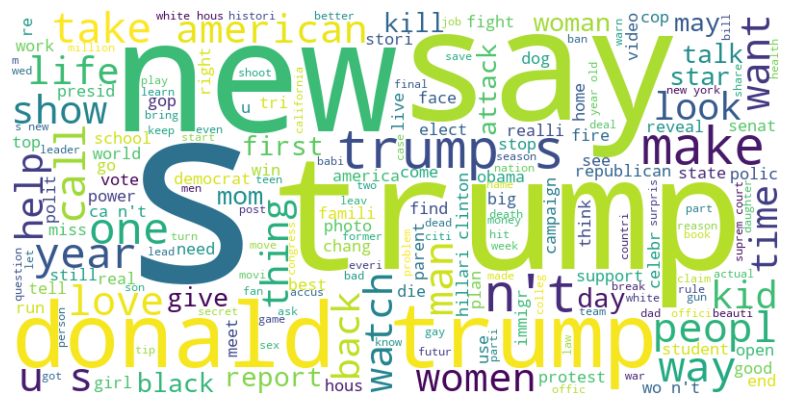

In [111]:
print('Non sarcastic word cloud:')

word_cloud(words_non_sarcastic)

Sarcastic word cloud:


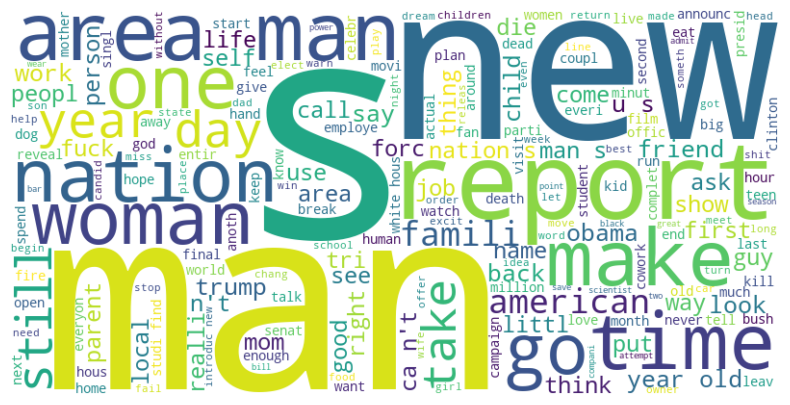

In [112]:
print('Sarcastic word cloud:')

word_cloud(words_sarcastic)

* From the word clouds, it is clear to see some **same words in both classes word clouds**, therefore, this words are more likely to **not be highly significant** for the prediction.

Now, in order to visualize the most frequent unique words, we plot the ***word cloud*** for each category.

Non sarcastic uniques word cloud:


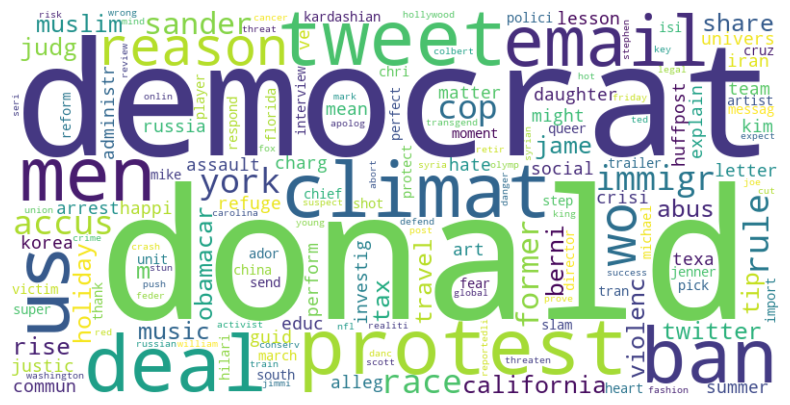

In [113]:
print('Non sarcastic uniques word cloud:')

word_cloud([word for word, count in unique_non_sarcastic])

Sarcastic uniques word cloud:


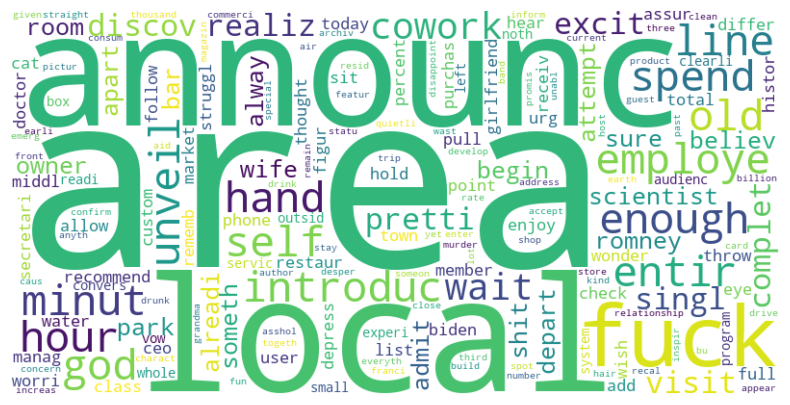

In [114]:
print('Sarcastic uniques word cloud:')

word_cloud([word for word, count in unique_sarcastic])

* Therefore, it is clear the **different topics** on each set like some curse words and other related topics.

### Verifying **unique words count**.

In order to check the **unique words proportion** mean based on the first ***N*** most common words, a graph is plotted along with the *Least Squares Line* to verify a trend.

In [115]:
final_x = 1000
most_common_non_sarcastic = FreqDist(words_non_sarcastic).most_common(final_x)
most_common_sarcastic = FreqDist(words_sarcastic).most_common(final_x)

def get_unique_common_words(n, sarcastic=unique_sarcastic, non_sarcastic=words_non_sarcastic):
    unique_words = [word for word, count in most_common_sarcastic[:n] if word not in [word for word, count in most_common_non_sarcastic[:n]]]

    return len(unique_words)

points = {x_coord:float(get_unique_common_words(x_coord))  for x_coord in range(final_x)}

mmq_m, mmq_b = np.polyfit(list(points.keys()), list(points.values()), 1)

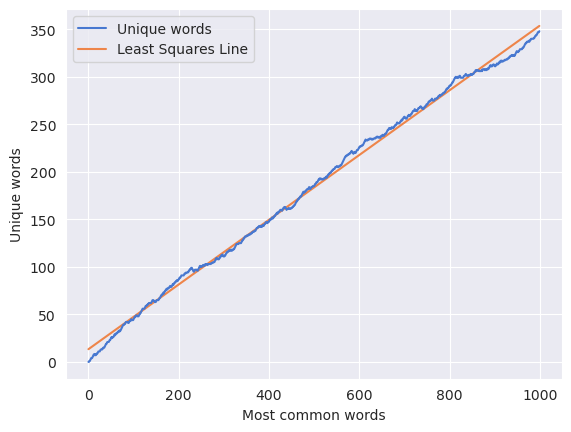

LSM line: 0.340*x + 13.392


In [116]:
x, y = np.array(list(points.keys())), list(points.values())
y_fit = mmq_m * x + mmq_b

sns.lineplot(x=x, y=y, markers='o', label='Unique words', zorder=2)
plt.plot(x, y_fit, label='Least Squares Line', zorder=1)

plt.legend()
plt.ylabel('Unique words')
plt.xlabel('Most common words')
plt.show()

print(f'LSM line: {mmq_m:.3f}*x + {mmq_b:.3f}')

#### Least Squares Method Line: `y = 0.340*x + 13.392`

* According to the graph, it is clear to see a **increasing trend** of the unique most common words in each class in relation to the ***N*** most common tokens.

* Therefore, it is reasonable to assume a ***~34%*** ratio of unique words among the common words in each category of sarcasm, which indicates a **statistical relevance related to the words used** in the sentence analysed, **insight explored on the modeling step**.

### Verifying words's **grammatical classes** and comparing between the target classes.

At this moment is desired to extract the words's radicals grammatical classes and compare the classes proportion between non-sarcastic and sarcastic headlines. In order to do this, it is use the `pos_tag` method from `nltk` library to classify the words.

In [117]:
sarcasm_df['gramatical_classes'] = sarcasm_df['tokens'].apply(nltk.pos_tag)

sarcasm_df['gramatical_classes'].head()

0    [(former, JJ), (versac, NN), (store, NN), (cle...
1    [('roseann, POS), (reviv, NN), (catch, NN), (t...
2    [(mom, JJ), (start, NN), (fear, VBP), (son, NN...
3    [(boehner, NN), (want, VBP), (wife, NN), (list...
4    [(j.k., NN), (rowl, NN), (wish, JJ), (snape, N...
Name: gramatical_classes, dtype: object

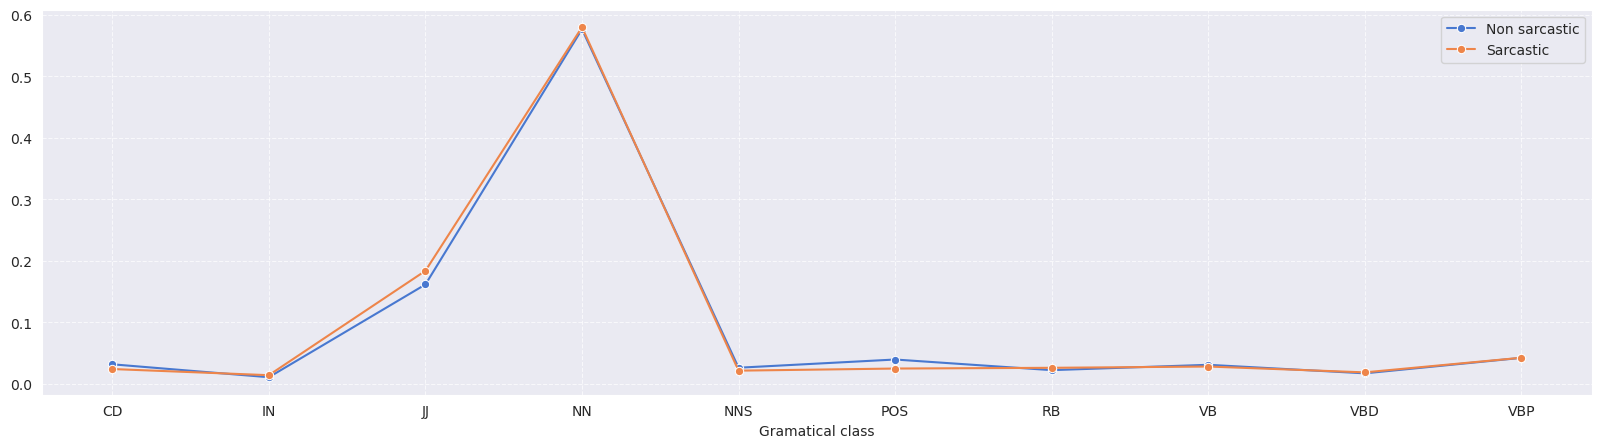

In [118]:
words_classes = sarcasm_df.explode('gramatical_classes')
words_classes[['word_stem', 'class']] = pd.DataFrame(words_classes['gramatical_classes'].tolist(), index=words_classes.index)

groups = words_classes.drop(columns=['gramatical_classes']).groupby('is_sarcastic')

plt.figure(figsize=(20, 5))

for target_att, variables in groups:
    classes_count = variables['class'].value_counts(normalize=True).sort_index()
    
    proportion_df = pd.DataFrame({'class': classes_count.index, 'proportion': classes_count.values})

    proportion_df = proportion_df[proportion_df['proportion'] >= 0.01]

    sns.lineplot(data=proportion_df, x='class', y='proportion', label='Non sarcastic' if target_att == 0 else 'Sarcastic', marker='o')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Gramatical class')
plt.ylabel('')
plt.legend()
plt.show()

* Based on the graph, it is possible to infer that the words distribution is **considerably similar** between non-sarcastic and sarcastic headlines, mainly on the most frequent classes, the **nouns**, with some minor differences on the less frequent classes.

* Therefore, despite the very similar distribution, there is a probability to the grammatical classes count show some **statistical relevance**.

### Verifying words **similarities** with ***PCA*** and ***Word2Vec***.

To visualize whether words in each category have a certain type of **similarity separation region boundary**, we use the ***Word2Vec*** alongside with the ***PCA*** method to **reduce the dimensionality** and plot the most frequent words on a ***2D*** dimension.

In [119]:
most_common_sarcastic = [[word] for word, count in FreqDist(words_sarcastic).most_common(200)]
most_common_non_sarcastic = [[word] for word, count in FreqDist(words_non_sarcastic).most_common(200)]

* First, the ***Word2Vec*** model is trained with all of the first *200* most common words and plot the word representation points.

In [120]:
model = Word2Vec(most_common_sarcastic + most_common_non_sarcastic, vector_size=500, window=8, min_count=1, workers=4)

word_vectors_sarcastic = [model.wv[word[0]] for word in most_common_sarcastic]
word_vectors_non_sarcastic = [model.wv[word[0]] for word in most_common_non_sarcastic]
word_vectors = word_vectors_non_sarcastic + word_vectors_sarcastic

pca = PCA(n_components=2)
pca.fit(word_vectors)

words_sarcastic_2d, words_non_sarcastic_2d = pca.transform(word_vectors_sarcastic), pca.transform(word_vectors_non_sarcastic)

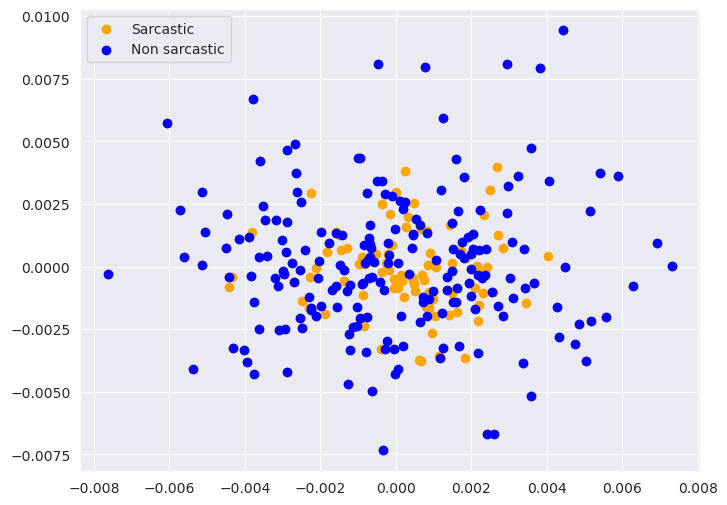

In [121]:
plt.figure(figsize=(8, 6))

plt.scatter(*zip(*words_sarcastic_2d), color='orange', label='Sarcastic')
plt.scatter(*zip(*words_non_sarcastic_2d), color='blue', label='Non sarcastic')

plt.legend()
plt.show()

* According to the graph, it is clear that **do not exist a explict separation boundary** between the classes, exiting a center region that sarcastic headlines concentrates, therefore a **more complex** machine learning model is indicated to be used.

To check wheter the model show a different behaviour by training with **unique words**, extracting the specifics of each class.

In [122]:
most_common_sarcastic = [[word] for word, count in FreqDist(words_sarcastic).most_common(500)]
most_common_non_sarcastic = [[word] for word, count in FreqDist(words_non_sarcastic).most_common(500)]

unique_non_sarcastic = [word for word in most_common_non_sarcastic if word not in most_common_sarcastic]
unique_sarcastic = [word for word in most_common_sarcastic if word not in most_common_non_sarcastic]

unique = unique_non_sarcastic + unique_sarcastic

In [123]:
model = Word2Vec(sentences=unique, vector_size=50000, window=8, min_count=1, workers=4)

word_vectors_sarcastic = [model.wv[word[0]] for word in unique_sarcastic]
word_vectors_non_sarcastic = [model.wv[word[0]] for word in unique_non_sarcastic]
word_vectors = word_vectors_non_sarcastic + word_vectors_sarcastic

pca = PCA(n_components=2)
pca.fit(word_vectors)

words_sarcastic_2d, words_non_sarcastic_2d = pca.transform(word_vectors_sarcastic), pca.transform(word_vectors_non_sarcastic)

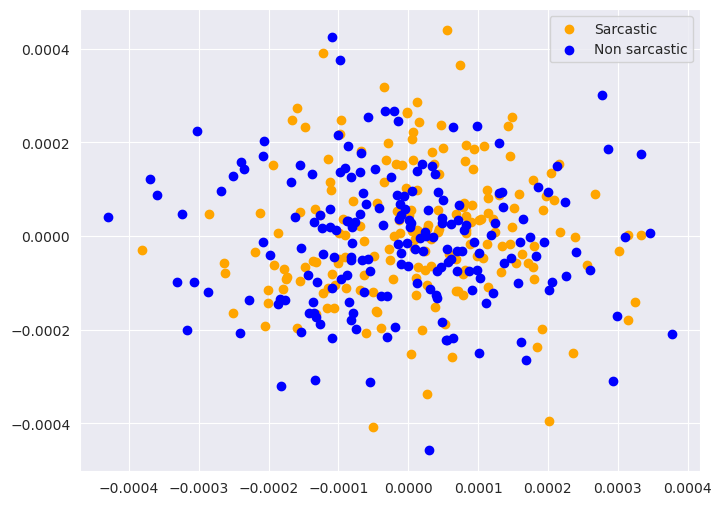

In [124]:
plt.figure(figsize=(8, 6))

plt.scatter(*zip(*words_sarcastic_2d), color='orange', label='Sarcastic')
plt.scatter(*zip(*words_non_sarcastic_2d), color='blue', label='Non sarcastic')

plt.legend()
plt.show()

* Based on the graph, the **distribution complexity keeps unchanged**, with **no explicit separation boundary** in ***2D***, which indicates a **more complex model** to predict.